In [53]:
import SITSpinOneMFT as sit
import SIT_noise_plaquette as plaq
import numpy as np 
from scipy import integrate as intg
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as mclr


In [2]:
Lx = 15
Ly = 15
Ej = 1.
Ec = sit.xymodel.generate_Ec_disorder(Lx,Ly,3.,3.05)

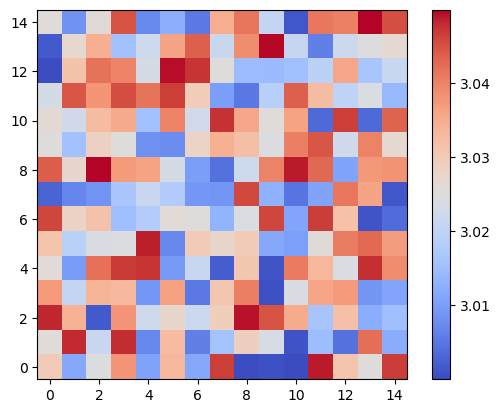

In [202]:
plt.imshow(Ec,origin='lower',cmap='coolwarm')
plt.colorbar()
plt.show()

In [203]:
model = sit.xymodel(Lx,Ly,Ej,Ec)

In [204]:
dt = model.find_GS(niter=4,stepsize=0.1)

In [205]:
print(dt)

67.21806788444519


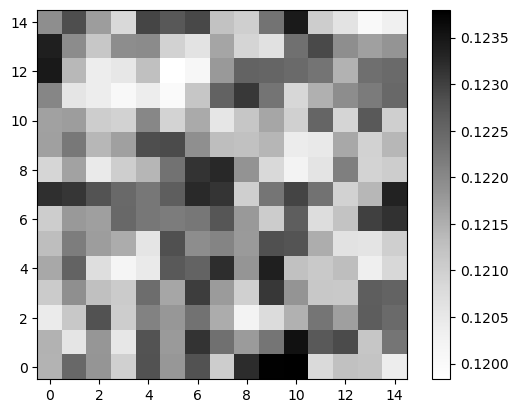

In [206]:
plt.imshow(sit.xymodel.charge_squared(model.gs_wf),origin='lower',cmap='Greys')
plt.colorbar()
plt.show()

In [207]:
flux = 2.3
echo_times = np.array([0.,10.,20.])
nsample = 300
sample_times = np.linspace(-2.,echo_times[-1]+5.,nsample)

In [208]:
echo = sit.xyecho(model,echo_times,flux,sample_times)
echo.calc_echo()

In [209]:
c2_vs_t = sit.xymodel.charge_squared(echo.wf)
m_vs_t = sit.xymodel.magnetization(echo.wf)


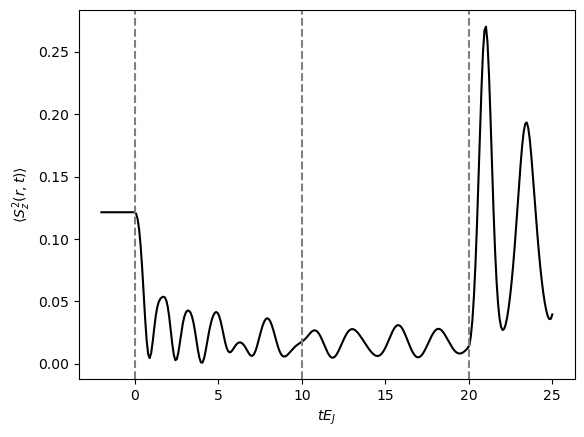

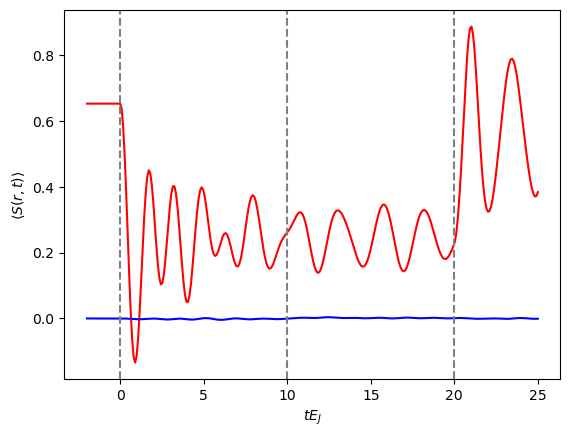

In [210]:
plt.plot(echo.sample_times,c2_vs_t[0,0,:],color='black')
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S_z^2(r,t)\rangle$')
for i in range(len(echo_times)):
    plt.axvline(echo_times[i],linestyle='dashed',color='gray')
plt.show()

plt.plot(echo.sample_times,m_vs_t[1,0,0,:],color='red')
plt.plot(echo.sample_times,m_vs_t[2,0,0,:],color='blue')
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S(r,t)\rangle$')
for i in range(len(echo_times)):
    plt.axvline(echo_times[i],linestyle='dashed',color='gray')
plt.show()

In [211]:
flux = 2.3
echo_times = np.array([0.,1.,20.])
nsample = 300
sample_times = np.linspace(-2.,echo_times[-1]+5.,nsample)

In [212]:
echo = sit.xyecho(model,echo_times,flux,sample_times)
echo.calc_echo()

In [213]:
c2_vs_t = sit.xymodel.charge_squared(echo.wf)
m_vs_t = sit.xymodel.magnetization(echo.wf)


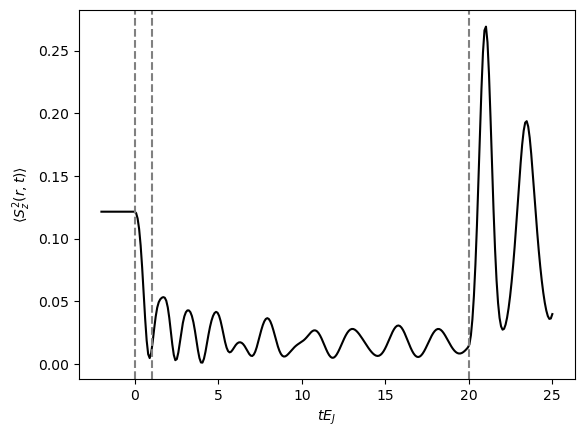

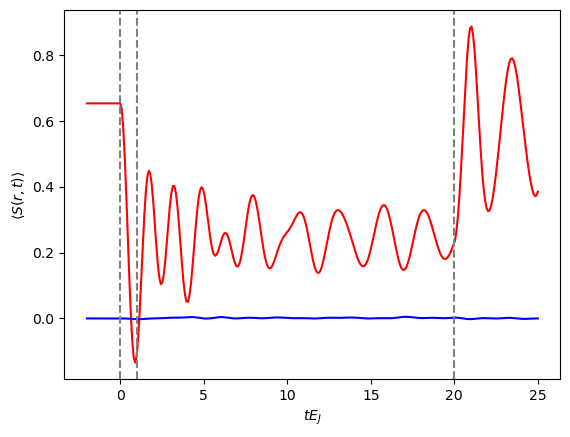

In [214]:
plt.plot(echo.sample_times,c2_vs_t[0,0,:],color='black')
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S_z^2(r,t)\rangle$')
for i in range(len(echo_times)):
    plt.axvline(echo_times[i],linestyle='dashed',color='gray')
plt.show()

plt.plot(echo.sample_times,m_vs_t[1,0,0,:],color='red')
plt.plot(echo.sample_times,m_vs_t[2,0,0,:],color='blue')
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S(r,t)\rangle$')
for i in range(len(echo_times)):
    plt.axvline(echo_times[i],linestyle='dashed',color='gray')
plt.show()

In [157]:
hahn_echo_p = sit.xyecho(model,echo_times,flux,sample_times)
hahn_echo_m = sit.xyecho(model,echo_times,-flux,sample_times)

In [158]:
hahn_echo_p.calc_echo()
hahn_echo_m.calc_echo()

In [159]:
c2_vs_t_p = sit.xymodel.charge_squared(hahn_echo_p.wf)
m_vs_t_p = sit.xymodel.magnetization(hahn_echo_p.wf)
c2_vs_t_m = sit.xymodel.charge_squared(hahn_echo_m.wf)
m_vs_t_m = sit.xymodel.magnetization(hahn_echo_m.wf)

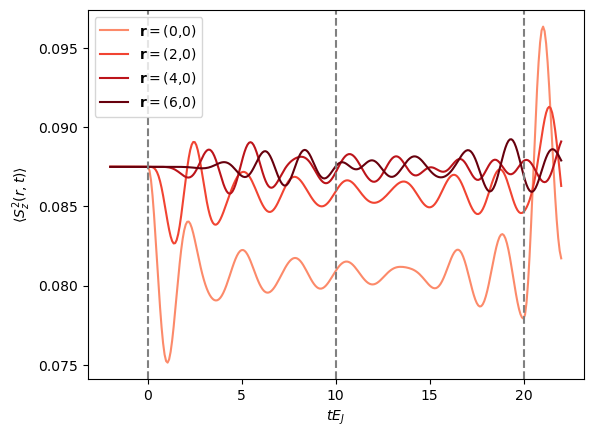

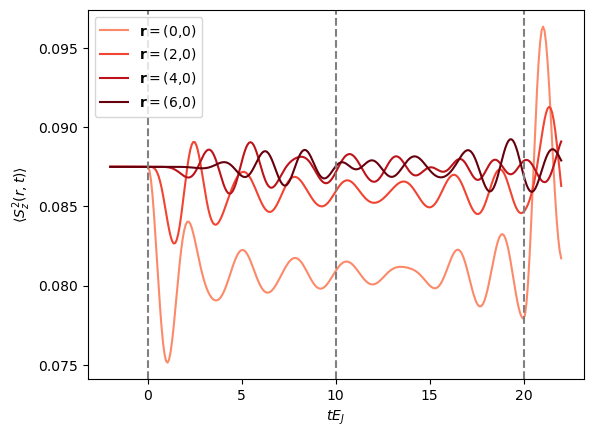

In [160]:
sites = [[0,0],[2,0],[4,0],[6,0]]
clrs = cm.Reds(np.linspace(0.4,1.,len(sites)))
for i in range(len(sites)):
    plt.plot(hahn_echo_p.sample_times,c2_vs_t_p[sites[i][0],sites[i][1],:],label=r'$\mathbf{r}=($'+str(sites[i][0])+","+str(sites[i][1])+r'$)$',color=clrs[i])
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S_z^2(r,t)\rangle$')
for i in range(len(echo_times)):
    plt.axvline(echo_times[i],linestyle='dashed',color='gray')
plt.legend()
plt.show()

for i in range(len(sites)):
    plt.plot(hahn_echo_m.sample_times,c2_vs_t_m[sites[i][0],sites[i][1],:],label=r'$\mathbf{r}=($'+str(sites[i][0])+","+str(sites[i][1])+r'$)$',color=clrs[i])
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S_z^2(r,t)\rangle$')
for i in range(len(echo_times)):
    plt.axvline(echo_times[i],linestyle='dashed',color='gray')
plt.legend()
plt.show()

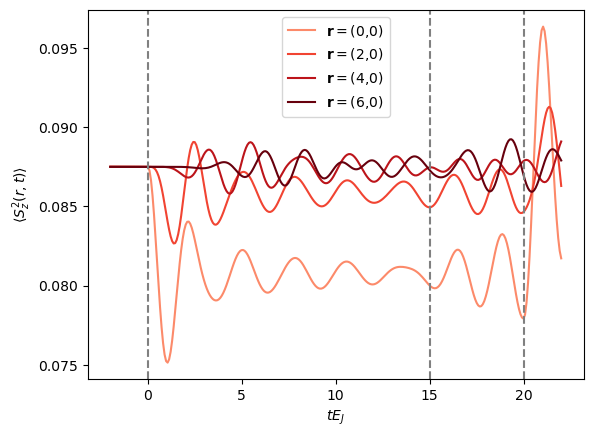

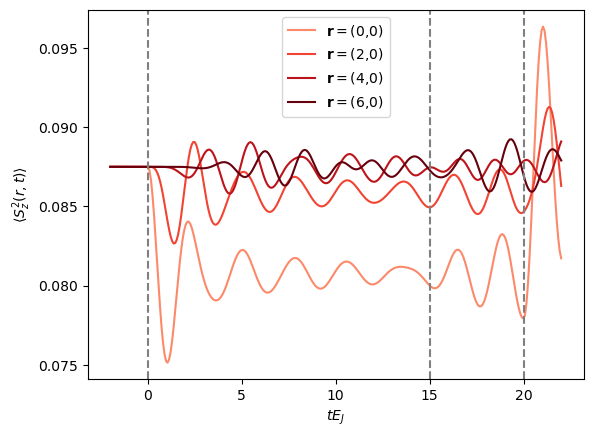

In [155]:
sites = [[0,0],[2,0],[4,0],[6,0]]
clrs = cm.Reds(np.linspace(0.4,1.,len(sites)))
for i in range(len(sites)):
    plt.plot(hahn_echo_p.sample_times,c2_vs_t_p[sites[i][0],sites[i][1],:],label=r'$\mathbf{r}=($'+str(sites[i][0])+","+str(sites[i][1])+r'$)$',color=clrs[i])
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S_z^2(r,t)\rangle$')
for i in range(len(echo_times)):
    plt.axvline(echo_times[i],linestyle='dashed',color='gray')
plt.legend()
plt.show()

for i in range(len(sites)):
    plt.plot(hahn_echo_m.sample_times,c2_vs_t_m[sites[i][0],sites[i][1],:],label=r'$\mathbf{r}=($'+str(sites[i][0])+","+str(sites[i][1])+r'$)$',color=clrs[i])
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S_z^2(r,t)\rangle$')
for i in range(len(echo_times)):
    plt.axvline(echo_times[i],linestyle='dashed',color='gray')
plt.legend()
plt.show()


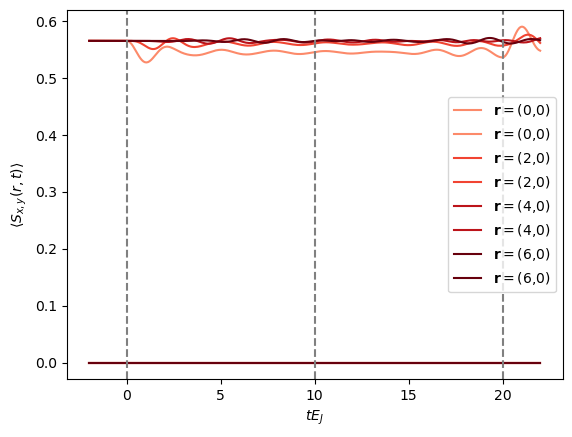

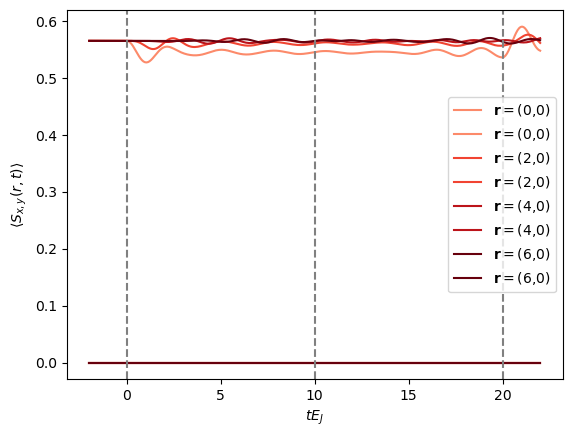

In [150]:
for i in range(len(sites)):
    plt.plot(hahn_echo_p.sample_times,m_vs_t_p[1,sites[i][0],sites[i][1],:],label=r'$\mathbf{r}=($'+str(sites[i][0])+","+str(sites[i][1])+r'$)$',color=clrs[i])
    plt.plot(hahn_echo_p.sample_times,m_vs_t_p[2,sites[i][0],sites[i][1],:],label=r'$\mathbf{r}=($'+str(sites[i][0])+","+str(sites[i][1])+r'$)$',color=clrs[i])
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S_{x,y}(r,t)\rangle$')
for i in range(len(echo_times)):
    plt.axvline(echo_times[i],linestyle='dashed',color='gray')
plt.legend()
plt.show()

for i in range(len(sites)):
    plt.plot(hahn_echo_m.sample_times,m_vs_t_m[1,sites[i][0],sites[i][1],:],label=r'$\mathbf{r}=($'+str(sites[i][0])+","+str(sites[i][1])+r'$)$',color=clrs[i])
    plt.plot(hahn_echo_m.sample_times,m_vs_t_m[2,sites[i][0],sites[i][1],:],label=r'$\mathbf{r}=($'+str(sites[i][0])+","+str(sites[i][1])+r'$)$',color=clrs[i])
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle S_{x,y}(r,t)\rangle$')
for i in range(len(echo_times)):
    plt.axvline(echo_times[i],linestyle='dashed',color='gray')
plt.legend()
plt.show()

In [60]:
Loschmidt_echo = np.prod(sit.xymodel.overlap(hahn_echo_p.wf,hahn_echo_m.wf),axis=(0,1))

(300,)

In [61]:
loschmidt_echo_single_site = sit.xymodel.overlap(hahn_echo_p.wf,hahn_echo_m.wf)

In [62]:
loschmidt_echo_single_site.shape

(6, 6, 300)

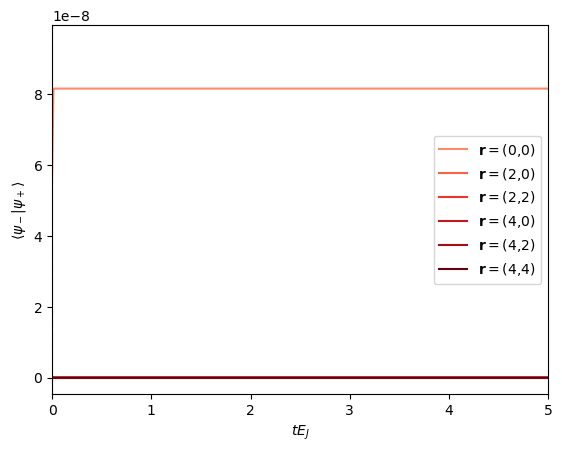

In [63]:
sites = [[0,0],[2,0],[2,2],[4,0],[4,2],[4,4]]
clrs = cm.Reds(np.linspace(0.4,1.,len(sites)))
for i in range(len(sites)):
    plt.plot(hahn_echo_p.sample_times,np.abs(loschmidt_echo_single_site[sites[i][0],sites[i][1],:])-1.,label=r'$\mathbf{r}=($'+str(sites[i][0])+","+str(sites[i][1])+r'$)$',color=clrs[i])
plt.xlabel(r'$tE_J$')
plt.ylabel(r'$\langle \psi_-|\psi_+\rangle$')
plt.axvline(echo_times[0],linestyle='dashed',color='gray')
plt.axvline(echo_times[1],linestyle='dashed',color='gray')
#plt.axvline(echo_times[2],linestyle='dashed',color='gray')
plt.xlim(0.,5.)
plt.legend()
plt.show()

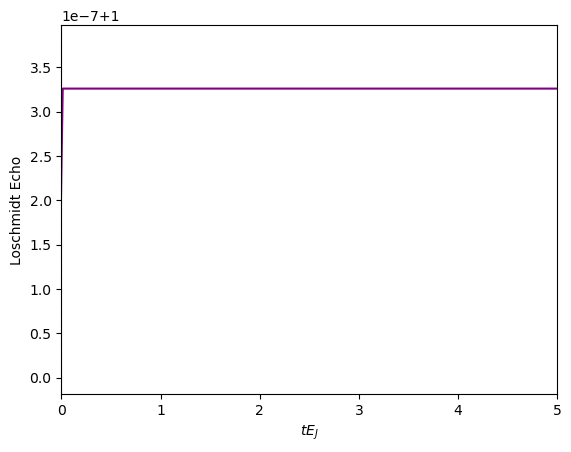

In [64]:
plt.plot(sample_times,np.abs(Loschmidt_echo),color='purple')
plt.xlabel(r'$tE_J$')
plt.ylabel(r'Loschmidt Echo')
plt.axvline(echo_times[0],linestyle='dashed',color='gray')
plt.axvline(echo_times[1],linestyle='dashed',color='gray')
plt.xlim(0.,5.)
#plt.axvline(echo_times[2],linestyle='dashed',color='gray')
plt.show()

In [99]:
Ej = 1.
Ec = 3.8
flux = 2.3

nH = 100
hahn_times = np.linspace(0.01,100.,nH)
echos = np.zeros(nH,dtype=complex)

for i in range(nH):
    echo_times = np.array([0.,hahn_times[i],2.*hahn_times[i]])
    sample_times = echo_times
    wf_p = plaq.evolve_quench(Ec,Ej,echo_times,flux,sample_times)
    wf_m = plaq.evolve_quench(Ec,Ej,echo_times,-flux,sample_times)
    echos[i] = np.sum(np.conjugate(wf_m)*wf_p,axis=(0))[-1]

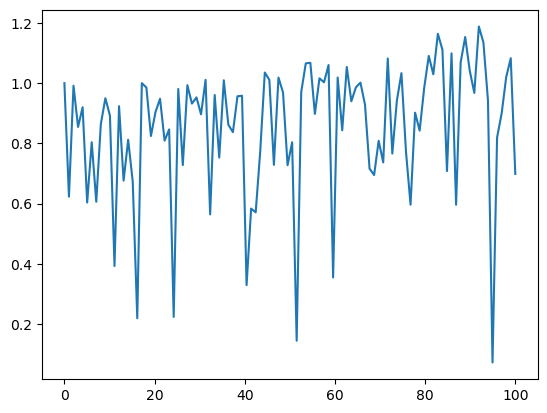

In [100]:
plt.plot(hahn_times,np.real(echos))
plt.show()

In [62]:
wf_p = plaq.evolve_quench(Ec,Ej,echo_times,flux,sample_times)
wf_m = plaq.evolve_quench(Ec,Ej,echo_times,-flux,sample_times)

In [63]:
sx = np.real( np.sum(np.conjugate(wf_p)*np.tensordot(plaq.S[0][1],wf_p,axes=[1,0]),axis=(0)) )
sy = np.real( np.sum(np.conjugate(wf_p)*np.tensordot(plaq.S[0][2],wf_p,axes=[1,0]),axis=(0)) )
c2 = np.real( np.sum(np.conjugate(wf_p)*np.tensordot(plaq.S[0][3]@plaq.S[0][3],wf_p,axes=[1,0]),axis=(0)) )

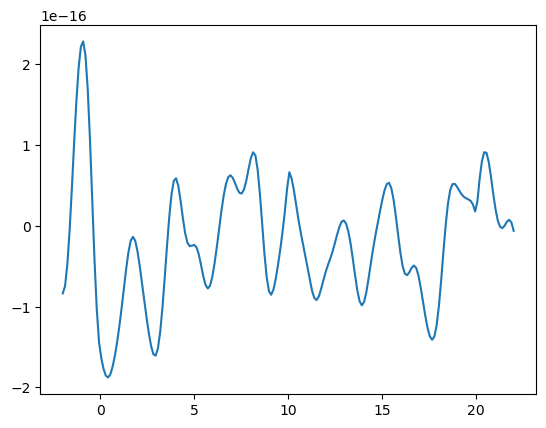

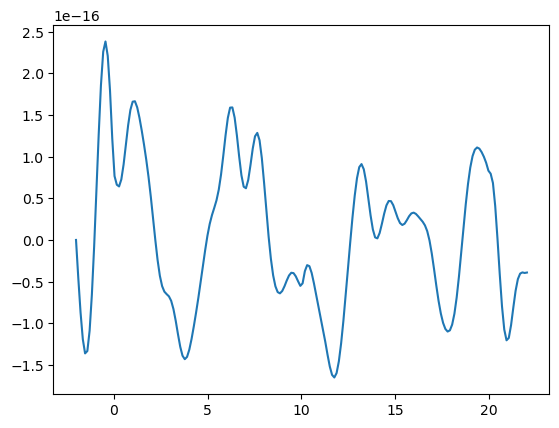

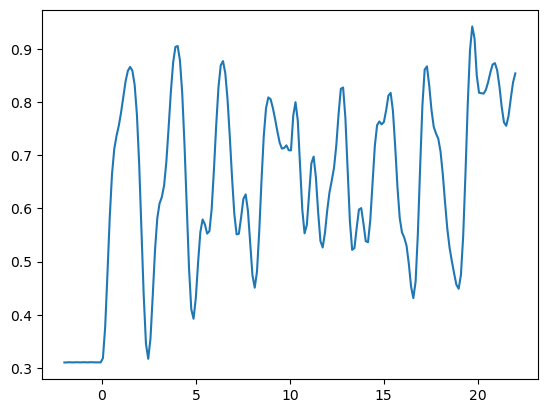

In [64]:
plt.plot(sample_times,sx)
plt.show()
plt.plot(sample_times,sy)
plt.show()
plt.plot(sample_times,c2)
plt.show()

In [65]:
overlap = np.sum(np.conjugate(wf_m)*wf_p,axis=(0))

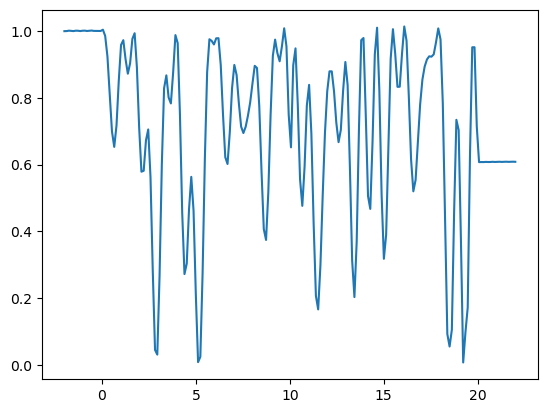

In [66]:
plt.plot(sample_times,np.abs(overlap))
plt.show()

In [1]:
import QMC_square as qmc
import SITSpinOneMFT as sit
import numpy as np 
from scipy import integrate as intg
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as mclr


In [8]:
EJ = 1.
EC = 0.05
T = 0.8
L = 6
M = 32
sim = qmc.QMC(EJ,EC,T,L,M)

In [9]:
nsample = 100
nburn = 0
nstep = 10

In [10]:
sim.set_sampling(nburn,nsample,nstep)

In [11]:
sim.burn()

In [12]:
sim.sample()

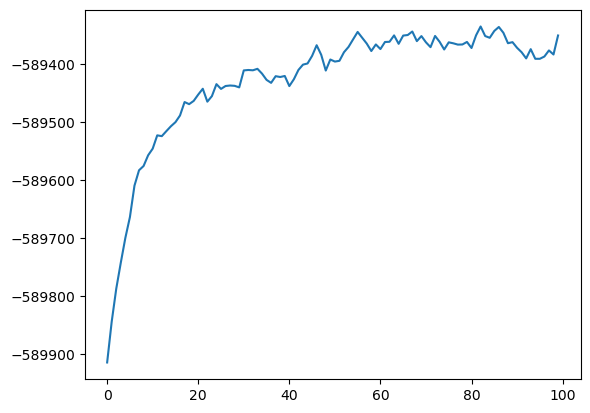

In [13]:
plt.plot(sim.action_samples)
plt.show()

In [2]:
EJ = 1.
EC = 0.05
T = 0.8
L = 6
Ms = [2,4,8,16,32]
nsample = 30
energies = np.zeros((len(Ms),nsample))

In [3]:
for i in range(len(Ms)):
    sim = qmc.QMC(EJ,EC,T,L,Ms[i])
    nburn = 0
    nstep = 5*sim.L*sim.L*sim.M*sim.M
    sim.set_sampling(nburn,nsample,nstep)
    sim.burn()
    sim.sample()
    energies[i,:] = sim.action_samples[:]

    


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/jonathancurtis/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/hl/gwthrswx1clcrvqp3t0pjtxw0000gn/T/ipykernel_13668/3082251203.py", line 7, in <module>
    sim.sample()
  File "/Users/jonathancurtis/Google Drive/Projects/ETH/Charlotte-XY-model/src/QMC_square.py", line 295, in sample
  File "/Users/jonathancurtis/Google Drive/Projects/ETH/Charlotte-XY-model/src/QMC_square.py", line 77, in MCStep_random
    new_energy = -self.Kx*( np.cos(new_theta - self.thetas[x-1,y,t]) + np.cos(new_theta - self.thetas[(x+1)%self.L,y,t]) )
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jonathancurtis/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structure

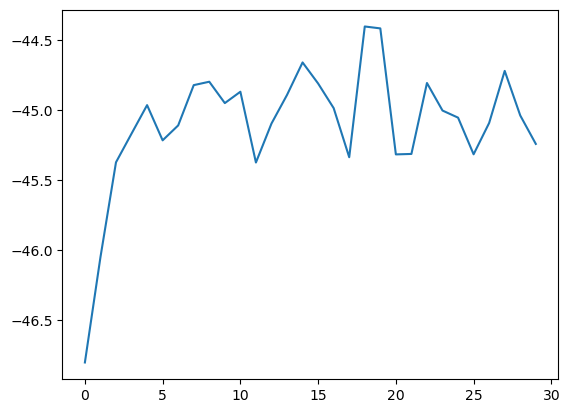

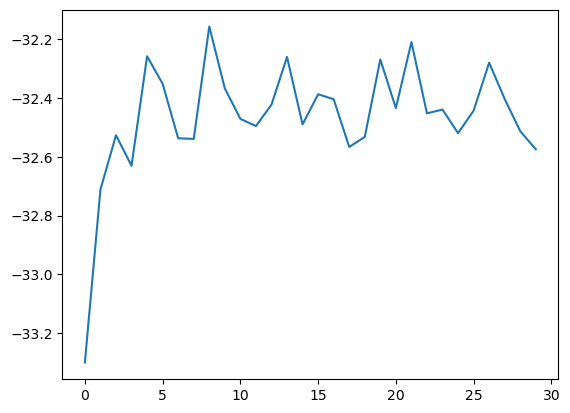

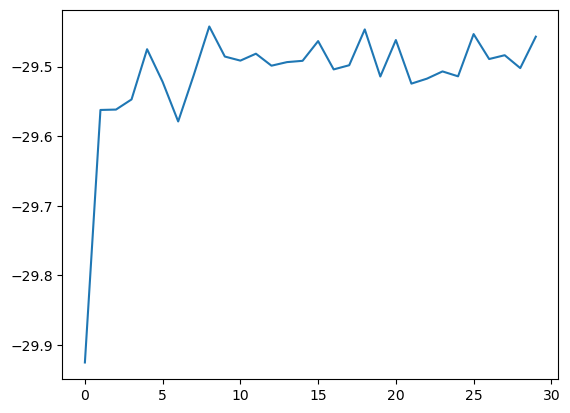

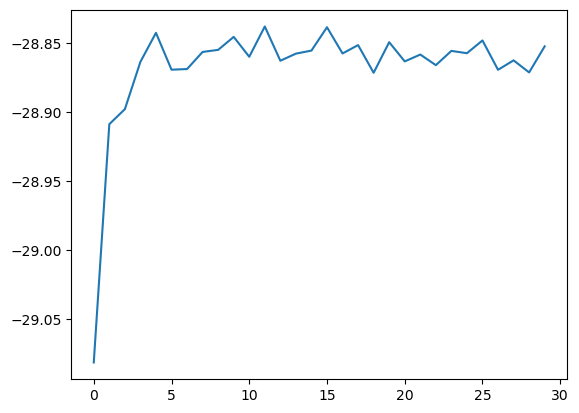

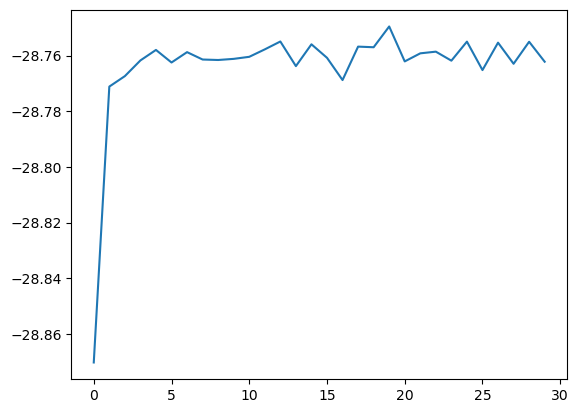

In [45]:
for i in range(len(Ms)):
    plt.plot(energies[i,:]/(Ms[i])**2)
    plt.show()

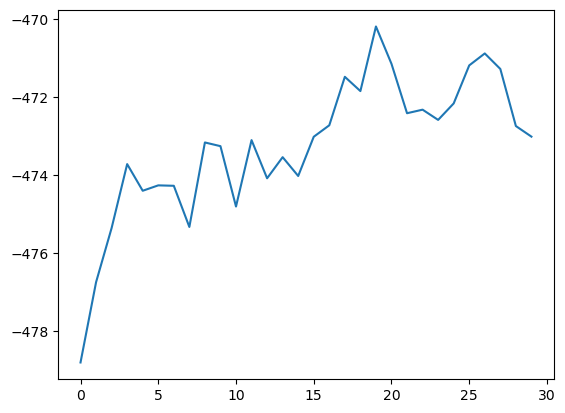

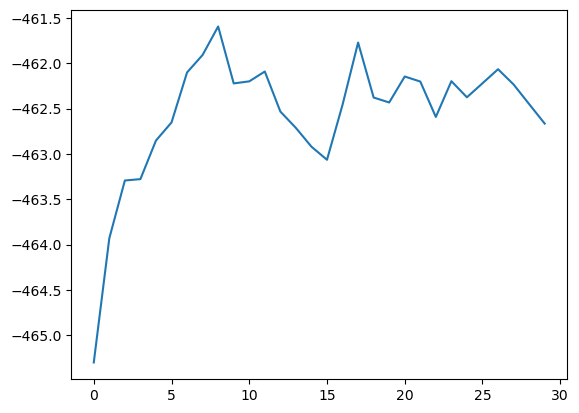

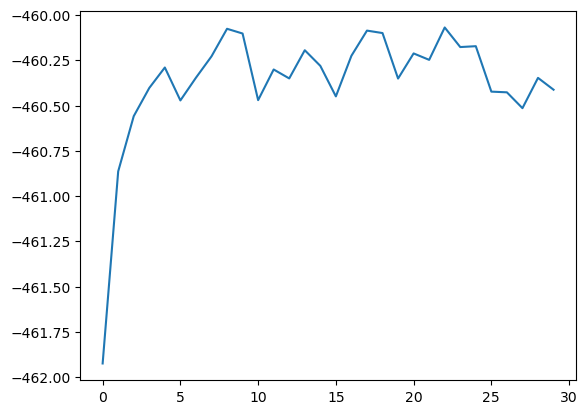

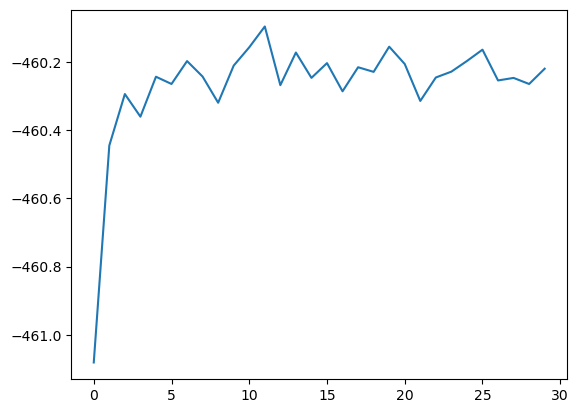

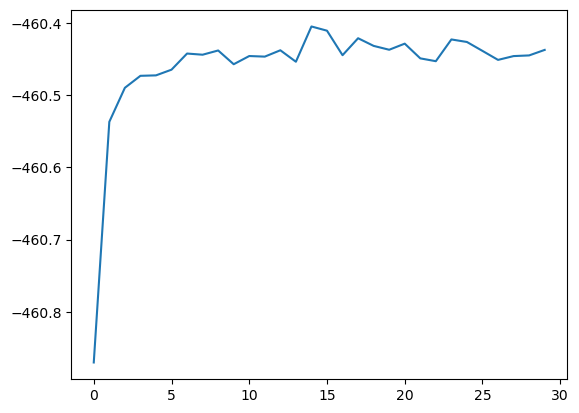

In [48]:
for i in range(len(Ms)):
    plt.plot(energies[i,:]/(Ms[i])**2)
    plt.show()